# Analysis of Overall Gender Ratio of LSE Staff

## Table of contents:

1. [Introduction](#introduction)
2. [Data Acquisition](#data-acquisition)
3. [Data Cleaning](#data-cleaning)
4. [Data Analysis](#data-analysis)
    * 4.1) [What is the overall gender ratio at LSE?](#research-question-1)
    * 4.2) [How does this gender ratio vary across different departments in LSE?](#research-question-2)
    * 4.3) [How does the gender ratio vary depending on the job title/role(ie assistant, professor…)?](#research-question-3)
5. [Conclusion](#conclusion)
6. [Extras](#extras)

___
<a id="introduction"></a>
## Introduction

Understanding the overall gender ratio at LSE is crucial for promoting equity, diversity, and inclusion. It reveals how gender balance varies across departments, exposing potential disparities and guiding interventions for a more inclusive environment. This analysis serves as a vital metric to assess progress towards gender equality initiatives and informs policy decisions aimed at fostering diversity. This analysis also offers insights into field-specific demand dynamics, mirroring labour market trends. This informs targeted recruitment, curriculum development, and support initiatives to ensure inclusivity. Examining gender representation disparities illuminates potential barriers, guiding proactive measures to address systemic inequities and foster inclusivity in academia. Ultimately, it enhances LSE's reputation as a leader in inclusive excellence within academia.

In comparing our research to existing studies like the `PSED-report-2021-22.pdf (lse.ac.uk)` and the Problem Set 5, Question 2 task, several crucial distinctions highlight the originality and significance of our project. While the PSED report provides valuable insights into the gender ratio of LSE as a whole, it lacks the granularity to examine department-specific variations and role-specific dynamics. Similarly, Problem Set 5, Question 2 focuses on a single department, limiting the scope of analysis. In contrast, our research endeavours to fill these gaps by employing web scraping techniques to gather data directly, ensuring a comprehensive examination of gender ratios across all departments and roles within LSE. By undertaking this holistic approach, our study promises to offer novel insights into gender representation and dynamics within the institution, contributing meaningfully to the discourse on diversity and equity in academia.

In this report, we are going to direct our analysis to answer four questions, which are:
   * What is the overall gender ratio at LSE?
   * How does this gender ratio vary across different departments in LSE?
   * How does the gender ratio vary depending on the job title/role(ie assistant, professor…)?

___
<a id="data-acquisition"></a>
## Data Acquisition

In order to anwer our research questions, we require a dataframe that includes name, role, department, and deduced gender of each staff. We will create the dataframe by scraping data from some LSE websites and using an [API](https://www.nameapi.org/en/live-demos/name-genderizer/) to help in deducing gender. The steps that we will take to get the data is as follows.

In [1]:
import requests
import pandas as pd
import numpy as np
import time
from bs4 import BeautifulSoup

### 1. Extract data of each staff from [LSE's people page](https://www.lse.ac.uk/people/search-people)
_The latest data collection was done at 28th April 2024._
* The [LSE webpage](https://www.lse.ac.uk/people/search-people) lists all staff in LSE with their name, department, role and link. Hence, it has most of the data we need except for gender.

In [2]:
base_url= 'https://www.lse.ac.uk/people/search-people'
params = {
    'pageIndex': 1
}

staff_data = []
while True:
    response = requests.get(base_url, params=params)
    soup = BeautifulSoup(response.content, 'lxml')
    staffs = soup.find_all('div', attrs={'class': 'card__content'})
    
    if len(staffs) == 0: # Finished scraping all staff data
        break
        
    for staff in staffs:
        person = {}
        # Scraping data from the page
        title = staff.find("span", attrs={'class': 'person__title'})
        forename = staff.find("span", attrs={'class': 'person__forename'})
        surname = staff.find("span", attrs={'class': 'person__surname'})
        position = staff.find("h4", attrs={'class': 'detail--position'})
        department = staff.find("h5", attrs={'class': 'detail--dept'})
        link = staff.find("a")
        
        # Storing in a dictionary
        person["title"] = title.get_text() if title else np.nan
        person["forename"] = forename.get_text() if forename else np.nan
        person["surname"] = surname.get_text() if surname else np.nan
        person["position"] = position.get_text() if position else np.nan
        person["department"] = department.get_text() if department else np.nan
        person["link"] = link["href"] if link else np.nan
        
        staff_data.append(person)
        
    params['pageIndex'] += 1 # Go to next page

In [3]:
staff_df = pd.DataFrame(staff_data)
staff_df.head(10)

title  forename           surname  \
0  Professor   Anthony          Atkinson   
1                Helen           Johnson   
2             Jeanette         L. Kaiser   
3         Dr     ﻿José   Manuel Pedraza    
4         Dr   Rishika             Yadav   
5         Ms    Nikita                 .   
6               Nikita                 .   
7                 Rong                 A   
8  Professor       Wim   A Van der Stede   
9         Dr     Fiona    Abades Barclay   

                                            position  \
0                   Emeritus Professor in Statistics   
1                                    Visiting Fellow   
2  PhD candidate in Environmental Policy and Deve...   
3                                         LSE Fellow   
4                  Events and Communications Officer   
5                                        PhD student   
6  Research Officer in Behavioural Science, PhD S...   
7                                   Research Student   
8                             Academic Board Nominee   
9                                   Research Officer   

                                          department  \
0                           Department of Statistics   
1                                         LSE Health   
2            Department of Geography and Environment   
3                           Department of Statistics   
4                                 European Institute   
5  Department of Psychological and Behavioural Sc...   
6                           The Inclusion Initiative   
7                            Department of Sociology   
8                Governance, Legal & Policy Division   
9             Department of Media and Communications   

                                                link  
0  https://lse.ac.uk/statistics/people/anthony-at...  
1  https://lse.ac.uk/lse-health/people/Visiting-F...  
2  https://lse.ac.uk/geography-and-environment/pe...  
3  https://lse.ac.uk/Statistics/People/Dr-Jos%C3%...  
4  https://lse.ac.uk/european-institute/people/Ya...  
5           https://lse.ac.uk/PBS/People/Nikita.aspx  
6           https://lse.ac.uk/tii/people/nikita.aspx  
7  https://lse.ac.uk/sociology/people/research-st...  
8  https://lse.ac.uk/News/presidential-search/peo...  
9  https://lse.ac.uk/media-and-communications/peo...

In [4]:
staff_df.shape

(3874, 6)

Assuming the data stored at the [site](https://www.lse.ac.uk/people/search-people) is complete. We have a total of 3874 rows of scraped staff data. 

### 2. Deduce the gender of each person in the DataFrame. 
* We note that there are several titles that is helpful to deduce gender. 

In [5]:
staff_df['title'].unique()

array(['Professor', '', 'Dr', 'Ms', 'Mr', 'Miss', 'Mrs'], dtype=object)

* Besides that, we will be using each person's respective link to deduce their gender, based on the number of occurences of gender-specific pronouns.

In [6]:
def deduce_gender_from_bio(bio_text):
    """
    Deduces the gender from bio text of staff page.
    returns: "Male", "Female" or np.nan
    """
    pronoun_counts = {
        "Female": 0,
        "Male": 0
    }
    
    empty_flag = True
    for word in bio_text.split():
        word = word.lower()
        if word in ["he", "his"]:
            pronoun_counts["Male"] += 1
            empty_flag = False
        elif word in ["she", "her"]:
            pronoun_counts["Female"] += 1
            empty_flag = False

    return np.nan if empty_flag else max(pronoun_counts, key=pronoun_counts.get)

Using both mentioned methods to deduce gender:

In [7]:
def get_gender(row):
    """
    Use data from the dataframe to determine the gender of each staff.
    Gender is deduced mainly from scraping on each staff's personal page or from their title (eg: 'Mr', 'Mrs').
    returns: "Male", "Female" or np.nan
    """
    # Deducing gender based on gender-specific titles
    title = row['title']
    if title in ["Mr"]:
        return "Male"
    elif title in ["Mrs", "Miss", "Ms"]:
        return "Female"
    
    # Unable to deduce gender through title, moving on to their link
    link = row['link']
    time.sleep(0.02)
    response = requests.get(link)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, 'lxml')
        bio = soup.find('div', attrs={"class":"people__bio"})
        if bio:
            gender = deduce_gender_from_bio(bio.get_text())
            return gender
    
    return np.nan
 
    
staff_df["gender"] = staff_df.apply(get_gender, axis = 1)

In [8]:
staff_df.head(10)

title  forename           surname  \
0  Professor   Anthony          Atkinson   
1                Helen           Johnson   
2             Jeanette         L. Kaiser   
3         Dr     ﻿José   Manuel Pedraza    
4         Dr   Rishika             Yadav   
5         Ms    Nikita                 .   
6               Nikita                 .   
7                 Rong                 A   
8  Professor       Wim   A Van der Stede   
9         Dr     Fiona    Abades Barclay   

                                            position  \
0                   Emeritus Professor in Statistics   
1                                    Visiting Fellow   
2  PhD candidate in Environmental Policy and Deve...   
3                                         LSE Fellow   
4                  Events and Communications Officer   
5                                        PhD student   
6  Research Officer in Behavioural Science, PhD S...   
7                                   Research Student   
8                             Academic Board Nominee   
9                                   Research Officer   

                                          department  \
0                           Department of Statistics   
1                                         LSE Health   
2            Department of Geography and Environment   
3                           Department of Statistics   
4                                 European Institute   
5  Department of Psychological and Behavioural Sc...   
6                           The Inclusion Initiative   
7                            Department of Sociology   
8                Governance, Legal & Policy Division   
9             Department of Media and Communications   

                                                link  gender  
0  https://lse.ac.uk/statistics/people/anthony-at...     NaN  
1  https://lse.ac.uk/lse-health/people/Visiting-F...  Female  
2  https://lse.ac.uk/geography-and-environment/pe...  Female  
3  https://lse.ac.uk/Statistics/People/Dr-Jos%C3%...     NaN  
4  https://lse.ac.uk/european-institute/people/Ya...     NaN  
5           https://lse.ac.uk/PBS/People/Nikita.aspx  Female  
6           https://lse.ac.uk/tii/people/nikita.aspx  Female  
7  https://lse.ac.uk/sociology/people/research-st...     NaN  
8  https://lse.ac.uk/News/presidential-search/peo...     NaN  
9  https://lse.ac.uk/media-and-communications/peo...  Female

In [9]:
staff_df.count()

title         3874
forename      3874
surname       3874
position      3874
department    3874
link          3874
gender        2672
dtype: int64

From the counts of all the columns filled with data above, there are still a lot of missing data in the `gender` column. Hence, we will be leveraging a [name genderizer API](https://namsor.app/features/gender-name/) (Namsor) to use the columns `forename` and `surname` to deduce gender based on the API.
* The Namsor API has a free tier of 5000 calls per month
* To replicate this part, it is needed to register an account on their [site](https://namsor.app/signup/), to get an API key.
* The relevant API documentation can be accessed through this [link](https://namsor.app/api-documentation/#genderize-name-batch)

In [10]:
import json

with open('keys.json') as f:
    keys = json.load(f)
    
api_key = keys["namsor"]["api_key"]

In [11]:
def get_gender_api(row):
    """
    Deduces the gender of a staff using their name, based on https://www.nameapi.org/en/live-demos/name-genderizer/
    returns: "Male", "Female" or np.nan
    """
    headers = {
        "X-API-KEY": api_key,
        "Accept": "application/json",
        "Content-Type": "application/json"
    }

    # Ignoring gender that is already deduced
    if row['gender'] is not np.nan:
        return row['gender']
    
    # Deducing missing gender using forename and surname with Namsor API
    url = "https://v2.namsor.com/NamSorAPIv2/api2/json/genderBatch"
    payload = {
      "personalNames": [
        {
          "firstName": row['forename'],
          "lastName": row['surname']
        }
      ]
    }

    response = requests.request("POST", url, json=payload, headers=headers)
    if response.status_code == 200:
        data = response.json()
        return data['personalNames'][0]['likelyGender'].capitalize()

    return np.nan


staff_df["gender"] = staff_df.apply(get_gender_api, axis=1)

In [12]:
staff_df.head(10)

title  forename           surname  \
0  Professor   Anthony          Atkinson   
1                Helen           Johnson   
2             Jeanette         L. Kaiser   
3         Dr     ﻿José   Manuel Pedraza    
4         Dr   Rishika             Yadav   
5         Ms    Nikita                 .   
6               Nikita                 .   
7                 Rong                 A   
8  Professor       Wim   A Van der Stede   
9         Dr     Fiona    Abades Barclay   

                                            position  \
0                   Emeritus Professor in Statistics   
1                                    Visiting Fellow   
2  PhD candidate in Environmental Policy and Deve...   
3                                         LSE Fellow   
4                  Events and Communications Officer   
5                                        PhD student   
6  Research Officer in Behavioural Science, PhD S...   
7                                   Research Student   
8                             Academic Board Nominee   
9                                   Research Officer   

                                          department  \
0                           Department of Statistics   
1                                         LSE Health   
2            Department of Geography and Environment   
3                           Department of Statistics   
4                                 European Institute   
5  Department of Psychological and Behavioural Sc...   
6                           The Inclusion Initiative   
7                            Department of Sociology   
8                Governance, Legal & Policy Division   
9             Department of Media and Communications   

                                                link  gender  
0  https://lse.ac.uk/statistics/people/anthony-at...    Male  
1  https://lse.ac.uk/lse-health/people/Visiting-F...  Female  
2  https://lse.ac.uk/geography-and-environment/pe...  Female  
3  https://lse.ac.uk/Statistics/People/Dr-Jos%C3%...  Female  
4  https://lse.ac.uk/european-institute/people/Ya...  Female  
5           https://lse.ac.uk/PBS/People/Nikita.aspx  Female  
6           https://lse.ac.uk/tii/people/nikita.aspx  Female  
7  https://lse.ac.uk/sociology/people/research-st...  Female  
8  https://lse.ac.uk/News/presidential-search/peo...    Male  
9  https://lse.ac.uk/media-and-communications/peo...  Female

In [13]:
staff_df['gender'].count()

3874

___
<a id="data-cleaning"></a>
## Data Cleaning

We have successfully obtained the data that we want from the LSE webpages and Namsor API. Based on the way we acquired the data, we do not need to deal with missing data (for the most relevant column of gender because of the use of Namsor API). Hence, we will move to transforming the data to get important attributes that are relevant to our analysis, then filtering the data to drop unnecessary columns, and observations.

### 1. Transforming the data

As we will be analyzing the gender distribution based on their roles, we will create some new columns `role` and `rank` based on the information provided at [https://info.lse.ac.uk/staff/divisions/Human-Resources/The-recruitment-toolkit/Role-profiles](https://info.lse.ac.uk/staff/divisions/Human-Resources/The-recruitment-toolkit/Role-profiles).

In [16]:
def get_role(position):
    position = position.lower()
    words_in_position = position.split()
    teaching_keywords = np.array(["fellow", "course tutor", "education", "teacher", "teaching"])
    
    if "research" in position and any([(keyword in position) for keyword in ["assistant", "fellow", "officer"]]):
        return "Research"
    elif ("policy fellow" in position) or ("policy officer" in position):
        return "Policy Fellow"
    elif any([(keyword in position) for keyword in teaching_keywords]):
        return "Teaching"
    elif any([word == "professor" for word in words_in_position]):
        return "Faculty"
    return np.nan
    
staff_df["role"] = staff_df["position"].apply(get_role)

In [17]:
staff_df.sample(10, random_state=1)

title         forename           surname  \
1141                       Marie             Fuchs   
2217                    Johannes              Matt   
2668         Dr            Seeta  Peña Gangadharan   
1395        Mrs            Laura            Havers   
2920         Dr            Barry            Rogers   
990          Dr            Idil            Elveris   
2402             Michael Buteera           Mugisha   
1330  Professor            Romeo          Gurakuqi   
2163         Dr            Laura              Mann   
1227         Dr          Patrick        Gill-Tiney   

                                               position  \
1141                         PhD Candidate in Economics   
2217                         PhD Candidate in Economics   
2668  Associate Professor, Deputy Head of Department...   
1395                Digital Graduate Teaching Assistant   
2920                     Visiting Professor in Practice   
990                                     Visiting Fellow   
2402  PhD student in the Department of International...   
1330                           Visiting Research Fellow   
2163   Associate Professor in International Development   
1227                                         LSE Fellow   

                                             department  \
1141                            Department of Economics   
2217                            Department of Economics   
2668             Department of Media and Communications   
1395  Department of Psychological and Behavioural Sc...   
2920  Department of Psychological and Behavioural Sc...   
990                                  European Institute   
2402            Department of International Development   
1330                Department of International History   
2163            Department of International Development   
1227              Department of International Relations   

                                                   link  gender      role  
1141  https://lse.ac.uk/economics/people/research-st...  Female       NaN  
2217  https://lse.ac.uk/economics/people/research-st...    Male       NaN  
2668  https://lse.ac.uk/media-and-communications/peo...  Female       NaN  
1395     https://lse.ac.uk/PBS/People/Laura-Havers.aspx  Female  Teaching  
2920  https://lse.ac.uk/PBS/People/Dr-Barry-Rogers.aspx    Male   Faculty  
990   https://lse.ac.uk/european-institute/people/vi...  Female  Teaching  
2402  https://lse.ac.uk/international-development/pe...    Male       NaN  
1330  https://lse.ac.uk/International-History/People...    Male  Research  
2163  https://lse.ac.uk/international-development/pe...  Female   Faculty  
1227  https://lse.ac.uk/international-relations/peop...    Male  Teaching

In [18]:
def get_rank(row):
    position = row['position'].lower()
    role = row['role']
    if role is np.nan:
        return np.nan
    
    if 'assistant' in position:
        return "Assistant"
    elif 'associate' in position:
        return "Associate"
    elif any([(keyword in position) for keyword in ['fellow', 'guest', 'course tutor', 'officer', 'visiting']]):
        return "Non-tenure"
    return "Full"
            
staff_df['rank'] = staff_df.apply(get_rank, axis=1)

In [19]:
staff_df.sample(10, random_state=1)

title         forename           surname  \
1141                       Marie             Fuchs   
2217                    Johannes              Matt   
2668         Dr            Seeta  Peña Gangadharan   
1395        Mrs            Laura            Havers   
2920         Dr            Barry            Rogers   
990          Dr            Idil            Elveris   
2402             Michael Buteera           Mugisha   
1330  Professor            Romeo          Gurakuqi   
2163         Dr            Laura              Mann   
1227         Dr          Patrick        Gill-Tiney   

                                               position  \
1141                         PhD Candidate in Economics   
2217                         PhD Candidate in Economics   
2668  Associate Professor, Deputy Head of Department...   
1395                Digital Graduate Teaching Assistant   
2920                     Visiting Professor in Practice   
990                                     Visiting Fellow   
2402  PhD student in the Department of International...   
1330                           Visiting Research Fellow   
2163   Associate Professor in International Development   
1227                                         LSE Fellow   

                                             department  \
1141                            Department of Economics   
2217                            Department of Economics   
2668             Department of Media and Communications   
1395  Department of Psychological and Behavioural Sc...   
2920  Department of Psychological and Behavioural Sc...   
990                                  European Institute   
2402            Department of International Development   
1330                Department of International History   
2163            Department of International Development   
1227              Department of International Relations   

                                                   link  gender      role  \
1141  https://lse.ac.uk/economics/people/research-st...  Female       NaN   
2217  https://lse.ac.uk/economics/people/research-st...    Male       NaN   
2668  https://lse.ac.uk/media-and-communications/peo...  Female       NaN   
1395     https://lse.ac.uk/PBS/People/Laura-Havers.aspx  Female  Teaching   
2920  https://lse.ac.uk/PBS/People/Dr-Barry-Rogers.aspx    Male   Faculty   
990   https://lse.ac.uk/european-institute/people/vi...  Female  Teaching   
2402  https://lse.ac.uk/international-development/pe...    Male       NaN   
1330  https://lse.ac.uk/International-History/People...    Male  Research   
2163  https://lse.ac.uk/international-development/pe...  Female   Faculty   
1227  https://lse.ac.uk/international-relations/peop...    Male  Teaching   

            rank  
1141         NaN  
2217         NaN  
2668         NaN  
1395   Assistant  
2920  Non-tenure  
990   Non-tenure  
2402         NaN  
1330  Non-tenure  
2163   Associate  
1227  Non-tenure

Next, we will be simplifying our data by reducing two columns, `forename` and `surname` into a single column `name`.

In [20]:
staff_df["name"] = staff_df["forename"] + " " + staff_df["surname"]
staff_df.head()

title  forename           surname  \
0  Professor   Anthony          Atkinson   
1                Helen           Johnson   
2             Jeanette         L. Kaiser   
3         Dr     ﻿José   Manuel Pedraza    
4         Dr   Rishika             Yadav   

                                            position  \
0                   Emeritus Professor in Statistics   
1                                    Visiting Fellow   
2  PhD candidate in Environmental Policy and Deve...   
3                                         LSE Fellow   
4                  Events and Communications Officer   

                                department  \
0                 Department of Statistics   
1                               LSE Health   
2  Department of Geography and Environment   
3                 Department of Statistics   
4                       European Institute   

                                                link  gender      role  \
0  https://lse.ac.uk/statistics/people/anthony-at...    Male   Faculty   
1  https://lse.ac.uk/lse-health/people/Visiting-F...  Female  Teaching   
2  https://lse.ac.uk/geography-and-environment/pe...  Female       NaN   
3  https://lse.ac.uk/Statistics/People/Dr-Jos%C3%...  Female  Teaching   
4  https://lse.ac.uk/european-institute/people/Ya...  Female       NaN   

         rank                    name  
0        Full       Anthony  Atkinson  
1  Non-tenure          Helen  Johnson  
2         NaN     Jeanette  L. Kaiser  
3  Non-tenure  ﻿José  Manuel Pedraza   
4         NaN          Rishika  Yadav

Using our methodology, a few things to note are:
* We treated `course tutor` and `officer` as non-tenure. The three mentioned ranks in the [LSE site](https://info.lse.ac.uk/staff/divisions/Human-Resources/The-recruitment-toolkit/Role-profiles) are only `Assistant`, `Associate`, and `Full`. Hence, we decided to treat all other positions as non-tenure.
* There are a number of observations with the word `visiting`. As it is not specifically mentioned in the [LSE site](https://info.lse.ac.uk/staff/divisions/Human-Resources/The-recruitment-toolkit/Role-profiles), we treated them as non-tenure based on the definition of a visiting scholar on [wikipedia](https://en.wikipedia.org/wiki/Visiting_scholar).

### 2. Filtering Data

Next, we will be dropping rows that contains the words `student` or `phd candidate` as our analysis will be focusing on LSE staff. We decided that observations with these words fits more to the consumer/student of LSE's educational institution instead of being recognized as a staff.

In [21]:
staff_df = staff_df[~(staff_df['position'].str.contains("student", case=False)) & ~(staff_df['position'].str.contains("phd candidate", case=False))]
staff_df.head(10)

title forename           surname                           position  \
0   Professor  Anthony          Atkinson   Emeritus Professor in Statistics   
1                Helen           Johnson                    Visiting Fellow   
3          Dr    ﻿José   Manuel Pedraza                          LSE Fellow   
4          Dr  Rishika             Yadav  Events and Communications Officer   
8   Professor      Wim   A Van der Stede             Academic Board Nominee   
9          Dr    Fiona    Abades Barclay                   Research Officer   
10                Aida          Abbashar                 Research Assistant   
13         Dr   James              Abdey    Associate Professor (Education)   
14         Dr    Ahmad              Abdi                Associate Professor   
15         Dr   Pejman    Abdolmohammadi             Former Visiting Fellow   

                                department  \
0                 Department of Statistics   
1                               LSE Health   
3                 Department of Statistics   
4                       European Institute   
8      Governance, Legal & Policy Division   
9   Department of Media and Communications   
10                      Middle East Centre   
13                Department of Statistics   
14               Department of Mathematics   
15                      Middle East Centre   

                                                 link  gender      role  \
0   https://lse.ac.uk/statistics/people/anthony-at...    Male   Faculty   
1   https://lse.ac.uk/lse-health/people/Visiting-F...  Female  Teaching   
3   https://lse.ac.uk/Statistics/People/Dr-Jos%C3%...  Female  Teaching   
4   https://lse.ac.uk/european-institute/people/Ya...  Female       NaN   
8   https://lse.ac.uk/News/presidential-search/peo...    Male       NaN   
9   https://lse.ac.uk/media-and-communications/peo...  Female  Research   
10  https://lse.ac.uk/middle-east-centre/people/ai...  Female  Research   
13  https://lse.ac.uk/statistics/people/james-abde...    Male  Teaching   
14  https://lse.ac.uk/Mathematics/People/Ahmad-Abd...    Male   Faculty   
15  https://lse.ac.uk/middle-east-centre/people/pe...    Male  Teaching   

          rank                    name  
0         Full       Anthony  Atkinson  
1   Non-tenure          Helen  Johnson  
3   Non-tenure  ﻿José  Manuel Pedraza   
4          NaN          Rishika  Yadav  
8          NaN     Wim A Van der Stede  
9   Non-tenure    Fiona Abades Barclay  
10   Assistant           Aida Abbashar  
13   Associate            James  Abdey  
14   Associate              Ahmad Abdi  
15  Non-tenure   Pejman Abdolmohammadi

Next, we will be dropping redundant/unnecessary columns and rearrange the columns to ease readability and further cleaning/analysis.

In [22]:
staff_df.drop(columns=['forename', 'surname', 'title', 'link', 'position'], inplace=True) # Dropping unnecessary columns
staff_df = staff_df.iloc[:, [4, 0, 2, 3, 1]] # Rearranging the columns
display(staff_df.head())
display(staff_df.tail())

name                           department      role  \
0       Anthony  Atkinson             Department of Statistics   Faculty   
1          Helen  Johnson                           LSE Health  Teaching   
3  ﻿José  Manuel Pedraza              Department of Statistics  Teaching   
4          Rishika  Yadav                   European Institute       NaN   
8     Wim A Van der Stede  Governance, Legal & Policy Division       NaN   

         rank  gender  
0        Full    Male  
1  Non-tenure  Female  
3  Non-tenure  Female  
4         NaN  Female  
8         NaN    Male

name                                         department  \
3869  Edoardo Zulato  Department of Psychological and Behavioural Sc...   
3870                                                                      
3871                                                                      
3872                                                                      
3873                                                                      

          role        rank gender  
3869  Teaching  Non-tenure   Male  
3870       NaN         NaN   Male  
3871       NaN         NaN   Male  
3872       NaN         NaN   Male  
3873       NaN         NaN   Male

Removing rows that have empty/invalid entries that will be irrelevant during analysis.

In [23]:
staff_df = staff_df[~(staff_df["name"] == " ")]
staff_df = staff_df[~(staff_df['department'] == "-- Please select --")]
display(staff_df.head())
display(staff_df.tail())

name                           department      role  \
0       Anthony  Atkinson             Department of Statistics   Faculty   
1          Helen  Johnson                           LSE Health  Teaching   
3  ﻿José  Manuel Pedraza              Department of Statistics  Teaching   
4          Rishika  Yadav                   European Institute       NaN   
8     Wim A Van der Stede  Governance, Legal & Policy Division       NaN   

         rank  gender  
0        Full    Male  
1  Non-tenure  Female  
3  Non-tenure  Female  
4         NaN  Female  
8         NaN    Male

name                                         department  \
3865    George Zouros                          Department of Mathematics   
3866    George Zouros                           Department of Statistics   
3867  Vladislav Zubok                Department of International History   
3868      Noah Zucker              Department of International Relations   
3869   Edoardo Zulato  Department of Psychological and Behavioural Sc...   

          role        rank gender  
3865  Teaching  Non-tenure   Male  
3866  Teaching  Non-tenure   Male  
3867   Faculty        Full   Male  
3868   Faculty   Assistant   Male  
3869  Teaching  Non-tenure   Male

Next, we will be dealing with duplicate data in the DataFrame. First, we take a look at the duplicate observations:

In [24]:
staff_df.value_counts()[:5]

name              department               role           rank        gender
Di Yang           LSE Health               Research       Non-tenure  Male      3
Yan Wang          School of Public Policy  Research       Non-tenure  Female    2
Francisco Torres  European Institute       Teaching       Non-tenure  Male      2
Erica Thompson    Data Science Institute   Policy Fellow  Non-tenure  Female    2
Richard Davies    School of Public Policy  Faculty        Full        Male      2
dtype: int64

To deal with the duplicate data, we decided to drop duplicates with the same name-department combination. This is to prevent double counting when analysing the gender distribution by departments. This also causes a particular person that is a staff of several departments to be counted separately for each department. We decided that this is acceptable because if we only pick one of the departments the person is a staff of, it will affect the accuracy of the analysis on other departments.

In [25]:
staff_df = staff_df.drop_duplicates(subset=['name', 'department'], keep='first')
staff_df.value_counts()[:5]

name                        department                            role      rank        gender
 Alexander (Sandy)  Pepper  Department of Management              Faculty   Full        Male      1
Mona Azadkia                Department of Statistics              Faculty   Assistant   Female    1
Mohamed Abouaziza           Department of Management              Research  Non-tenure  Male      1
Mohamed Saleh               Department of Economic History        Faculty   Associate   Male      1
Mohbuba Choudhury           Centre for Women, Peace and Security  Teaching  Non-tenure  Female    1
dtype: int64

Looking if there are persons that are counted as a staff for several departments:

In [26]:
staff_df['name'].value_counts()[:5]

Rishika Yadav         3
Mark Thatcher         2
Michael  Anderson     2
Delphine Polidori     2
Rebecca Simson        2
Name: name, dtype: int64

In [27]:
staff_df[staff_df['name'] == 'Margot Salomon']

name        department     role       rank  gender
2995  Margot Salomon    LSE Law School  Faculty  Associate  Female
2996  Margot Salomon  LSE Human Rights  Faculty  Associate  Female

From the observation above, this is what is expected and thus we are done with dealing with redundancies in the `name` column.

Next, we will be dealing with redundancies found at the `department` column. Here, we found that there are two pairs of similar departments/groups, which are `Conflict Research Group` with `Conflict and Civicness Research Group`, and `Department for Gender Studies` and `Department of Gender Studies`.

In [28]:
staff_df.loc[staff_df['department'] == 'Conflict Research Group', 'department'] = 'Conflict and Civicness Research Group'
staff_df.loc[staff_df['department'] == 'Department for Gender Studies', 'department'] = 'Department of Gender Studies'

From the data cleaning process done, the current state of the data is as follows:
- Our DataFrame consists of all previous data, having dropped only rows that contain the words `student` and `phd candidate` in the `position attribute`, and irrelevant rows such as those having ` ` (spacebar) as a name, and `-- Please select --` (a placeholder) as the department. 
- Even though there are a lot of rows with missing role and rank attributes, we decided to not drop them to get a more accurate answer for the question regarding the overall gender distribution of LSE staff.

In [29]:
df = staff_df.reset_index(drop=True)
df.shape

(2857, 5)

___
<a id="data-analysis"></a>
## Data Analysis

### Exploratory Data Analysis and Visualisation

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

In [31]:
df.describe(include="all")

name                              department      role  \
count            2857                                    2857      2215   
unique           2792                                      60         4   
top     Rishika Yadav  Department of Media and Communications  Teaching   
freq                3                                     247       986   

              rank gender  
count         2215   2857  
unique           4      2  
top     Non-tenure   Male  
freq          1259   1476

Since the data we have are not quantitative, there is not much insight we can gain from looking from the pre-defined describe function provided for pandas DataFrame. However, in relevance to our main analysis, we can see that there is more `Male` staff than `Female` staff, with an amount of 1473. Besides that, we can see that our current data consists of staff from `Department of Media and Communications` the most, and a majority of the staff with a `Teaching` role, and with a rank of `Non-tenure`.

Before doing further analysis, we will be defining functions that will be used during analysis and visualisation.

In [32]:
def get_analysis(pivot_df):    
    new_df = pivot_df.copy()    
    new_df['Total'] = (new_df["Female"] + new_df["Male"]).astype("int")
    new_df[["Female Percentage", "Male Percentage"]] = new_df[["Female", "Male"]].apply(lambda x: x/sum(x), axis = 1)
    new_df['Majority'] = 'None'
    new_df.loc[new_df['Female'] < new_df['Male'], 'Majority'] = 'Male'
    new_df.loc[new_df['Female'] > new_df['Male'], 'Majority'] = 'Female'
    new_df.loc[new_df['Majority'] == 'Male', 'Ratio'] = new_df['Male'] / new_df['Female']
    new_df.loc[new_df['Majority'] == 'Female', 'Ratio'] = new_df['Female'] / new_df['Male']
    new_df.loc[new_df['Majority'] == 'None', 'Ratio'] = 1
    return new_df

In [33]:
def plot_stacked_bar(by_dept_data, title):    
    departments = by_dept_data.index
    ind = np.arange(len(departments))

    # Width of the bars
    width = 0.9

    fig, ax = plt.subplots(figsize=(10, 5))
    male_counts = by_dept_data['Male']
    female_counts = by_dept_data['Female']
    
    # Plotting
    p1 = ax.bar(ind, male_counts, width, label='Male', color='skyblue')
    p2 = ax.bar(ind, female_counts, width, bottom=male_counts, label='Female', color='pink')

    # Labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Counts')
    ax.set_title(title)
    ax.set_xticks(ind)
    ax.set_xticklabels(departments, rotation='vertical')
    ax.legend()

    # Show the figure
    plt.show()

Moving on, we will calculate statistics from the data and visualize our findings, in order to answer the research questions we set for this project.

**_Important Note: The following analysis and visualisation assumes the data we have is complete, correct and up to date._**

___
<a id="research-question-1"></a>
### Research Question 1: What is the overall gender distribution at LSE?

#### Analysis 1: Overall Gender Distribution
_This part of the analysis uses the whole cleaned DataFrame, removing all duplicates in the `name` attribute._

Since we already note that there are multiple instances of the same name in separate departments, we will removing the duplicate names to get a more accurate overall gender distribution. However, further analysis (for example, when considering gender distribution by department) will use the DataFrame without the duplicate names being removed.

In [34]:
removed_dup_names = df.drop_duplicates(subset=['name'], keep='first')
overall_dist = removed_dup_names.groupby("gender").size()
overall_dist /= removed_dup_names['gender'].size
overall_dist

gender
Female    0.479943
Male      0.520057
dtype: float64

<a id='plot-1'></a>
#### Plot 1: Gender Distribution Pie Chart
_This visualisation uses the DataFrame with removed duplicate names._

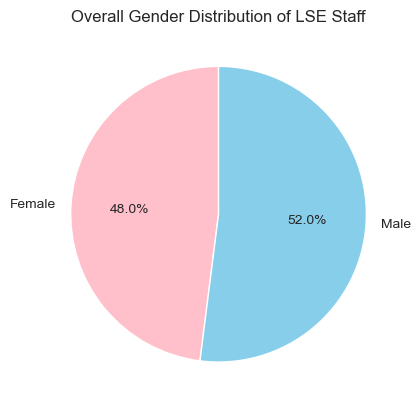

In [35]:
plt.pie(overall_dist, labels=overall_dist.keys(), colors=['pink', 'skyblue'], autopct='%1.1f%%', startangle=90)
plt.title('Overall Gender Distribution of LSE Staff');

From Analysis 1 and Plot 1:
- The overall gender distribution of LSE staff is approximately 52% for Male and 48% for Female. (At time of writing)
- In general, an ideal gender distribution would be an even balance of 50:50 ratio, however the overall gender distribution in LSE is dominated by the `Male` gender, but only by a small difference (approximately 4%, at time of writing).

Important things to note:
- This assumes that the data we have is currently up to date, where all staff who had already left LSE are not present in the data, and all staff who are new in LSE are present in the data.
- This also assumes that there is no double counting. We have already made an attempt to prevent double counting by removing duplicates in the name attribute.

___
<a id="research-question-2"></a>
### Research Question 2: How does this gender distribution vary across different departments in LSE?

<a id='analysis-2'></a>
#### Analysis 2: Gender Distribution by Department
_This part of the analysis uses the whole cleaned DataFrame._

To analyse the gender distribution of LSE staff by Department (and for analysis by role and rank), we will be creating a pivot table to count the number of `Male` and `Female` staff. Then, we will call the previously defined function `get_analysis` to do the rest of the analysis and return a new DataFrame.

Here are the descriptions for each attribute that will be used:
- `Female`: The number of Female staff for that category (department, role or rank).
- `Male`: The number of Male staff for that category.
- `Female Percentage`: The percentage of Female staff for that category. 
    - Calculated using \<Number of Female> / \<Total number of people in the category>
- `Male Percentage`: The percentage of Male staff for that category. 
    - Calculated using \<Number of Male> / \<Total number of people in the category>
- `Total`: The total number of people in the category.
- `Majority`: The gender majority in the category, either 'Female', 'Male' or 'None'.
- `Ratio`: The ratio of the minority to the majority. For example, a value of 2 indicates that the ratio of the gender minority to the gender majority is 1:2.
    - Calculated using \<Number of people with Gender Majority in the category> / \<Number of people with Gender Minority in the category>

In [36]:
by_dept = df.pivot_table(index='department', columns='gender', values='name', aggfunc='count').fillna(0).astype(int)
by_dept = get_analysis(by_dept)
by_dept.sort_values("Total", ascending=False)

gender                                              Female  Male  Total  \
department                                                                
Department of Media and Communications                 140   107    247   
Department of International Relations                   62    69    131   
International Inequalities Institute                    64    59    123   
Department of Economics                                 34    80    114   
Department of Management                                52    59    111   
LSE Law School                                          45    65    110   
Middle East Centre                                      60    49    109   
Department of Government                                40    66    106   
European Institute                                      39    59     98   
Department of International History                     36    61     97   
Department of Psychological and Behavioural Sci...      43    48     91   
Department of Statistics                                31    55     86   
School of Public Policy                                 39    47     86   
Department of Mathematics                               22    64     86   
Department of Geography and Environment                 29    55     84   
LSE Health                                              40    35     75   
Department of Sociology                                 38    32     70   
Department of Economic History                          22    45     67   
Centre for Women, Peace and Security                    59     8     67   
Department of Anthropology                              37    29     66   
Department of International Development                 35    30     65   
Department of Social Policy                             35    29     64   
Language Centre                                         37    19     56   
Care Policy and Evaluation Centre (CPEC)                34    22     56   
Department of Gender Studies                            47     9     56   
Firoz Lalji Institute for Africa                        26    27     53   
Department of Methodology                               22    29     51   
Department of Finance                                   16    30     46   
Latin America and Caribbean Centre (LACC)               31    15     46   
Department of Health Policy                             20    20     40   
Department of Accounting                                13    23     36   
LSE IDEAS                                               14    15     29   
The Inclusion Initiative                                17     8     25   
LSE Library                                             14     5     19   
Department of Law                                        8    10     18   
Hellenic Observatory                                     5    12     17   
LSE Consulting                                          11     6     17   
LSEE Research on South Eastern Europe                    9     6     15   
United States Centre                                     4    10     14   
LSE Cities                                               7     6     13   
Centre for Philosophy of Natural and Social Sci...       5     6     11   
LSE Human Rights                                         8     2     10   
Department of Philosophy Logic and Scientific M...       2     7      9   
International Development                                2     7      9   
Conflict and Civicness Research Group                    4     3      7   
LSE Enterprise                                           5     1      6   
Governance, Legal & Policy Division                      4     2      6   
Mannheim Centre for Criminology                          3     3      6   
Centre for Analysis of Risk and Regulation (CARR)        1     3      4   
Marshall Institute for Philanthropy and Social ...       1     3      4   
Data Science Institute                                   2     2      4   
LSE Research and Innovati

Since there are some departments from our data that have a very small amount of total number of staff (such as `Executive Office` and `Saw Swee Hock Southeast Asia Centre`), we will be creating another DataFrame with the `Total` attribute above a certain amount. This is to increase the relevance of some visualisations as the gender distribution will be based on a larger sample (in our case 5).

In [37]:
threshold = 5 # Change this to see the gender distribution of depts. above a certain total
above_threshold = by_dept[by_dept['Total'] > threshold].copy()
above_threshold.sort_values('Total', ascending=False)

gender                                              Female  Male  Total  \
department                                                                
Department of Media and Communications                 140   107    247   
Department of International Relations                   62    69    131   
International Inequalities Institute                    64    59    123   
Department of Economics                                 34    80    114   
Department of Management                                52    59    111   
LSE Law School                                          45    65    110   
Middle East Centre                                      60    49    109   
Department of Government                                40    66    106   
European Institute                                      39    59     98   
Department of International History                     36    61     97   
Department of Psychological and Behavioural Sci...      43    48     91   
Department of Mathematics                               22    64     86   
School of Public Policy                                 39    47     86   
Department of Statistics                                31    55     86   
Department of Geography and Environment                 29    55     84   
LSE Health                                              40    35     75   
Department of Sociology                                 38    32     70   
Department of Economic History                          22    45     67   
Centre for Women, Peace and Security                    59     8     67   
Department of Anthropology                              37    29     66   
Department of International Development                 35    30     65   
Department of Social Policy                             35    29     64   
Language Centre                                         37    19     56   
Care Policy and Evaluation Centre (CPEC)                34    22     56   
Department of Gender Studies                            47     9     56   
Firoz Lalji Institute for Africa                        26    27     53   
Department of Methodology                               22    29     51   
Latin America and Caribbean Centre (LACC)               31    15     46   
Department of Finance                                   16    30     46   
Department of Health Policy                             20    20     40   
Department of Accounting                                13    23     36   
LSE IDEAS                                               14    15     29   
The Inclusion Initiative                                17     8     25   
LSE Library                                             14     5     19   
Department of Law                                        8    10     18   
Hellenic Observatory                                     5    12     17   
LSE Consulting                                          11     6     17   
LSEE Research on South Eastern Europe                    9     6     15   
United States Centre                                     4    10     14   
LSE Cities                                               7     6     13   
Centre for Philosophy of Natural and Social Sci...       5     6     11   
LSE Human Rights                                         8     2     10   
Department of Philosophy Logic and Scientific M...       2     7      9   
International Development                                2     7      9   
Conflict and Civicness Research Group                    4     3      7   
LSE Enterprise                                           5     1      6   
Mannheim Centre for Criminology                          3     3      6   
Governance, Legal & Policy Division                      4     2      6   

gender                                              Female Percentage  \
department                                                              
Department of Media and Communications                       0.566802   
Department of International Re

To further understand the gender distribution of LSE staff based on Departments, we will look at several plots and visualisations:

#### Plot 2.1: Stacked Bar Chart of the Gender Distribution of the 20 Largest Departments in LSE
_This visualisation uses the `by_dept` DataFrame, limited to the top 20 largest department based on the `Total` attribute._

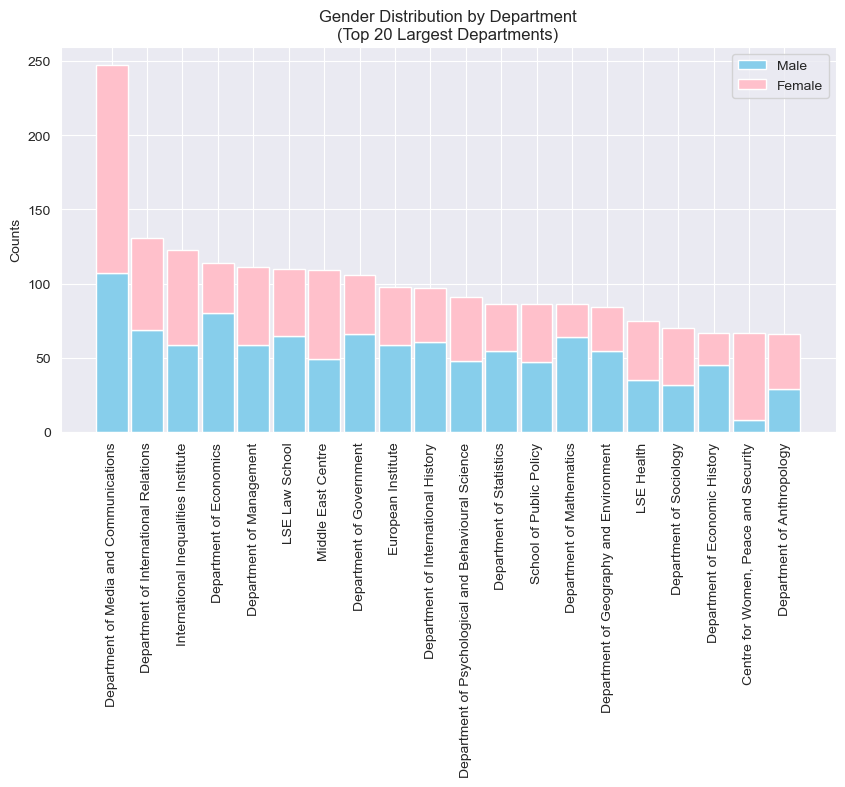

In [38]:
plot_stacked_bar(by_dept.sort_values('Total', ascending=False)[:20], "Gender Distribution by Department\n(Top 20 Largest Departments)")

Based on plot 2.1:
- For the 20 largest departments in LSE, the gender distribution seems to be fairly balanced, with most departments having a male majority.
- Even though most departments have a male majority, the disparity can be seen as not too noticeable.
- However, an exception is the `Centre for Women, Peace and Security`, having the largest gender disparity where the female staff outnumbers the male by a noticeably large amount. This is not suprising though, since it is a department focused on women.

#### Plot 2.2: Stacked Bar Chart of the Gender Distribution of the 20 Smallest Departments in LSE
_This visualisation uses the `by_dept` DataFrame, limited to the top 20 smallest department based on the `Total` attribute._

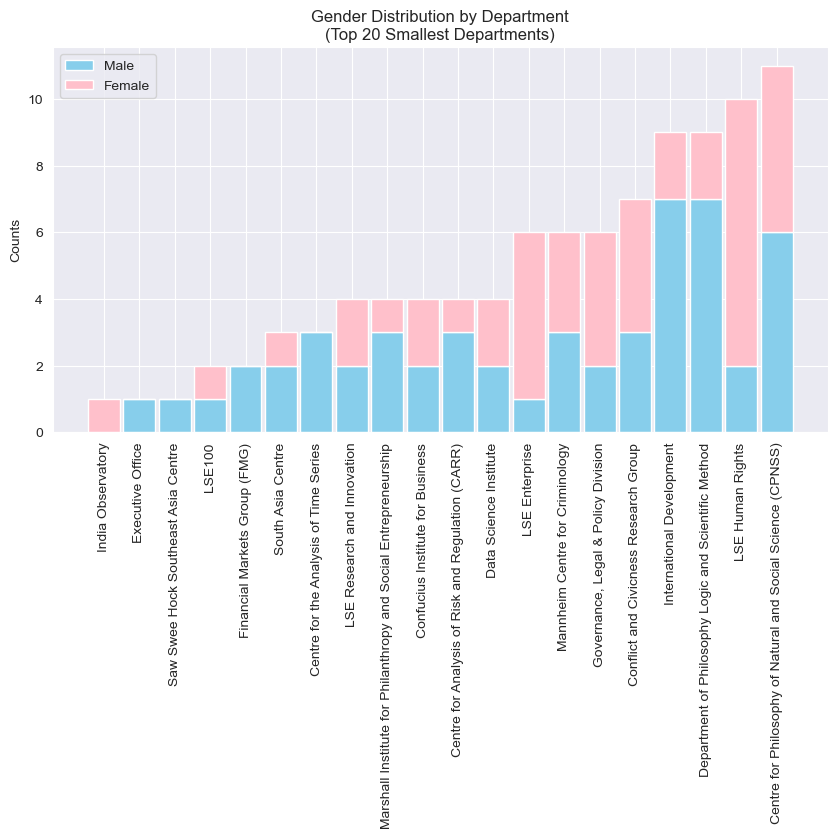

In [39]:
plot_stacked_bar(by_dept.sort_values('Total')[:20], "Gender Distribution by Department\n(Top 20 Smallest Departments)")

Based on plot 2.2:
- For the 20 smallest departments in LSE, the gender distribution by department seems to show a higher disparity. Noticeably, there are a lot more departments with a female majority compared to that of the 20 largest departments.
- However, by looking at the y-axis, we can see that the the department's size only range from 1 to 11. This could be the cause of why the gender distribution appears unbalanced.
- Logically, a department should not have a total staff number of 1 (such as `Executive Office`, `India Observatory`, etc), which suggests that either there is a mistake or error in the data.
- Hence, this shows the relevance of using `above_threshold` DataFrame for a better quality analysis moving forward.

From what we observed so far, a clear limitation of this analysis can be seen since it is logically not possible for a department to only have 1 staff. Hence, for further visualisations, we will use the `above threshold` DataFrame, assuming that the rest of the departments contained in `above threshold` are correct and up to date.

<a id='plot-2.3'></a>
#### Plot 2.3: Horizontal Bar Chart of the Gender Disparity based on Gender Ratio by Department
_This visualisation uses the `above_threshold` DataFrame, which is based on `by_dept`, but above our chosen threshold._

In order to have a more clear look at the gender disparity present in each department, we will be using the `Ratio` attribute contained in the `by_dept` DataFrame. A higher ratio means that the gender disparity is higher, which is undesirable.

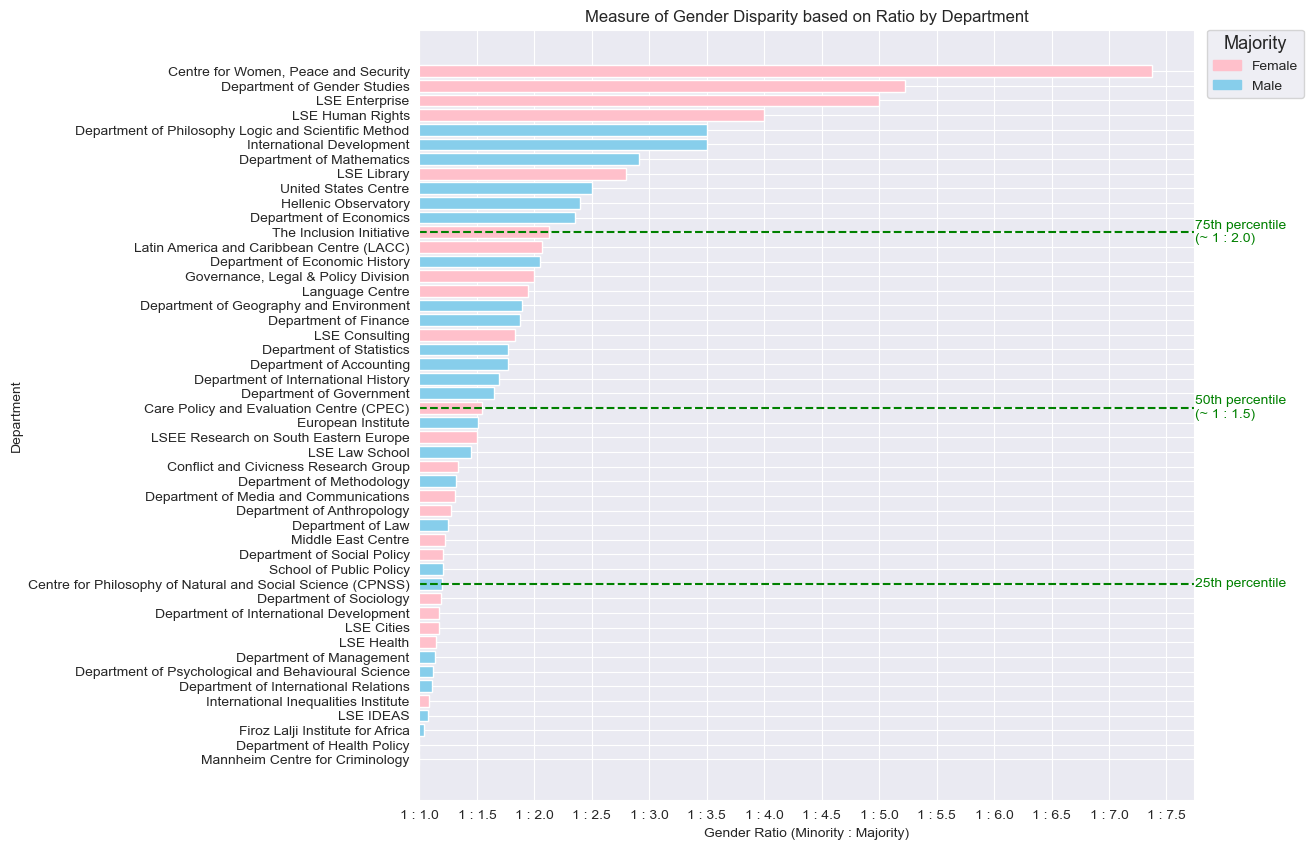

In [40]:
from matplotlib.ticker import FuncFormatter

plot_df = above_threshold.sort_values('Ratio')

plt.figure(figsize=(10, 10))
colors = plot_df['Majority'].map({'Male': 'skyblue', 'Female': 'pink', 'None': 'white'})  # Color mapping
plt.barh(plot_df.index, plot_df['Ratio'], color=colors)
plt.xlabel('Gender Ratio (Minority : Majority)')
plt.xlim(left=1)
plt.xticks(ticks=np.arange(1, 8, 0.5))
plt.ylabel('Department')
plt.title('Measure of Gender Disparity based on Ratio by Department')

quarter = plot_df['Majority'].size // 4
plt.axhline(quarter, color='green', linestyle='--')
plt.text(7.75, quarter, '25th percentile', color='green', verticalalignment='center', horizontalalignment='left')
plt.axhline(quarter * 2, color='green', linestyle='--')
plt.text(7.75, quarter * 2, '50th percentile\n(~ 1 : 1.5)', color='green', verticalalignment='center', horizontalalignment='left')
plt.axhline(quarter * 3, color='green', linestyle='--')
plt.text(7.75, quarter * 3, '75th percentile\n(~ 1 : 2.0)', color='green', verticalalignment='center', horizontalalignment='left')

formatter = FuncFormatter(lambda x, pos: f"1 : {round(x, 1)}")
plt.gca().xaxis.set_major_formatter(formatter)

# Custom legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
legend_labels = {'Female': 'pink', 'Male': 'skyblue'}
custom_handles = [plt.Rectangle((0,0),1,1, color=legend_labels[label]) for label in legend_labels]
plt.legend(custom_handles, legend_labels.keys(), title="Majority", loc='upper right', 
           bbox_to_anchor=(1.15, 1.01), title_fontsize='13')

plt.show()

From plot 2.3:
- Of the departments that does not have a balanced gender distribution, the most unbalanced departments are departments with a female majority.
- We have discussed about the `Centre for Women, Peace and Security`, but quite suprisingly the `Department of Gender Studies` has the second highest minority:majority ratio, which means that the department is one of the least gender diverse!
- There are only 3 departments that are have a completely balanced gender distribution (`Mannheim Centre for Criminology`, `Firoz Lalji Institute for Africa`, and `LSE Cities`).
- Approximately half of the departments have a gender disparity with ratio of atleast 1:1.5, which is equivalent to 40:60. While approximately a quarter of the departments in LSE have a gender disparity ratio of greater than 1:2. 

Thus, from what we have seen so far, the data shows that in general most departments have a considerably acceptable gender minority:majority ratio of 40:60. Even though the ideal distribution should be 50:50. In reality, there will be variances. However, from plot 2.3, we can see that there are also several departments that have severly unbalanced gender distributions. To understand more on possible reasons of this issue, we will try to look at the relation between number of staff in each department and gender disparity measures.

#### Plot 2.4: Scatter Plot of Total Number of Staff to the Percentage Difference of Genders in each Department
_This visualisation uses all of `above_threshold` DataFrame._

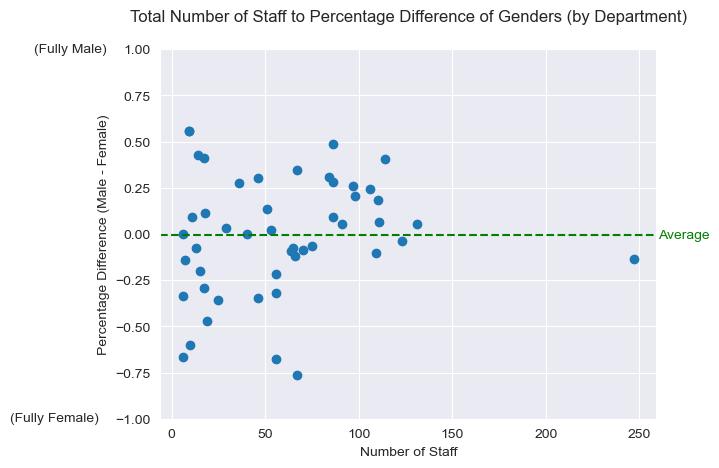

In [41]:
above_threshold['Percentage Difference'] = above_threshold['Male Percentage'] - above_threshold['Female Percentage']
plt.scatter(above_threshold['Total'], above_threshold['Percentage Difference'])
y_mean = np.mean(above_threshold['Percentage Difference'])
plt.ylim(bottom=-1, top=1)
plt.title('Total Number of Staff to Percentage Difference of Genders (by Department)', pad=20)
plt.xlabel('Number of Staff')
plt.ylabel('Percentage Difference (Male - Female)')
plt.axhline(y_mean, color='green', linestyle='--')
plt.text(260, y_mean, 'Average', color='green', verticalalignment='center', horizontalalignment='left')
plt.text(-35, 1, '(Fully Male)', va='center', ha='right')
plt.text(-39, -1, '(Fully Female)', va='center', ha='right');

In [42]:
y_mean

-0.005978899886286758

Suprisingly, even though the departments with highest gender disparity are women (as shown in plot 2.3, and as we can see from the more values being close to -0.75, compared to +0.75 in plot 2.4), there are more departments with a men majority which balances the average percentage to being close to 0. In addition, the scatter plot above, shows that there are no clear relations between the size of department and the measure of gender disparity based on percecntage difference.

<a id='plot-2.5'></a>
#### Plot 2.5: Scatter Plot of Total Number of Staff to the Gender Disparity based on Gender Ratio in each Department
_This visualisation uses all of `above_threshold` DataFrame._

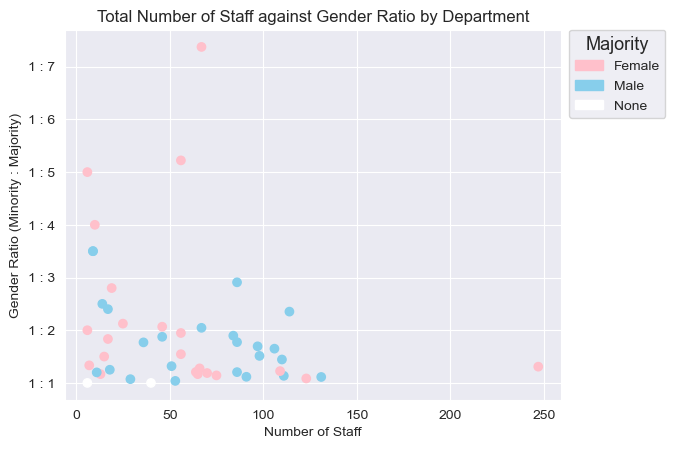

In [43]:
plot_plot_df = above_threshold.copy()
colors = plot_df['Majority'].map({'Female': 'pink', 'Male': 'skyblue', 'None': 'white'})
plt.scatter(plot_df['Total'], plot_df['Ratio'], c=colors)
formatter = FuncFormatter(lambda x, pos: f"1 : {int(x)}")
plt.gca().yaxis.set_major_formatter(formatter)
plt.title('Total Number of Staff against Gender Ratio by Department')
plt.xlabel('Number of Staff')
plt.ylabel('Gender Ratio (Minority : Majority)')

# Custom legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
legend_labels = {'Female': 'pink', 'Male': 'skyblue', 'None': 'white'}
custom_handles = [plt.Rectangle((0,0),1,1, color=legend_labels[label]) for label in legend_labels]
plt.legend(custom_handles, legend_labels.keys(), title="Majority", loc='upper right', bbox_to_anchor=(1.225, 1.02), title_fontsize='13')
plt.show();

From the scatter plot 2.5, there seems to not be a clear pattern, meaning they might be no relation between gender disparity and size of departments. We will also look at the correlation.

In [44]:
above_threshold.loc[:, ['Total', 'Ratio', 'Percentage Difference']].corr()

gender                    Total     Ratio  Percentage Difference
gender                                                          
Total                  1.000000 -0.224892               0.142618
Ratio                 -0.224892  1.000000              -0.385936
Percentage Difference  0.142618 -0.385936               1.000000

Filtering to only departments with Male majority:

In [45]:
above_threshold.loc[above_threshold['Majority'] == "Male", ['Total', 'Ratio', 'Percentage Difference']].corr()

gender                    Total     Ratio  Percentage Difference
gender                                                          
Total                  1.000000 -0.366979              -0.299928
Ratio                 -0.366979  1.000000               0.972470
Percentage Difference -0.299928  0.972470               1.000000

Filtering to only departments with Female majority:

In [46]:
above_threshold.loc[above_threshold['Majority'] == "Female", ['Total', 'Ratio', 'Percentage Difference']].corr()

gender                    Total     Ratio  Percentage Difference
gender                                                          
Total                  1.000000 -0.211520               0.346691
Ratio                 -0.211520  1.000000              -0.939139
Percentage Difference  0.346691 -0.939139               1.000000

Even though the visualisations suggest that there are no correlation between the size of departments and measures of gender disparity, the statistics suggest that there is indeed some correlation between these attributes. A thing to note is without separating the statistic by gender of `Majority`, the correlation between `Ratio` and `Percentage Difference` is small, which is counter-intuitive. But when we categorize by the gender `Majority`, the absolute values are closer to 1, which should be true.

- The statistics suggests that the total number of staff in a department has a negative correlation with gender disparity.
- Even though the correlation between `Total` and `Percentage Difference` for Female majority is positive, we can see that  the correlation between `Ratio` and `Percentage Difference` is approximately -1. This is caused by how we defined the value for `Percentage Difference` (Male Percentage - Female Percentage)
- Hence, we can deduce that based on the statistics we have, as the `Total` number of staff in each department increases, the gender disparity measure decreases, or equivalently the balance of gender distribution improves.

**_It is important to remember that a correlation does not mean causation_**

___
<a id="research-question-3"></a>
### Research Question 3: How does the gender ratio vary depending on the job title/role(ie assistant, professor…)?

#### Analysis 3: Gender Distribution by Role
_This part of the analysis uses the whole cleaned DataFrame._

In [47]:
by_role = df.pivot_table(index='role', columns='gender', values='name', aggfunc='count')
by_role = get_analysis(by_role)
by_role

gender         Female  Male  Total  Female Percentage  Male Percentage  \
role                                                                     
Faculty           341   584    925           0.368649         0.631351   
Policy Fellow      20     4     24           0.833333         0.166667   
Research          154   126    280           0.550000         0.450000   
Teaching          497   489    986           0.504057         0.495943   

gender        Majority     Ratio  
role                              
Faculty           Male  1.712610  
Policy Fellow   Female  5.000000  
Research        Female  1.222222  
Teaching        Female  1.016360

#### Plot 3: Bar Chart of the Gender Disparity based on Gender Ratio by Role

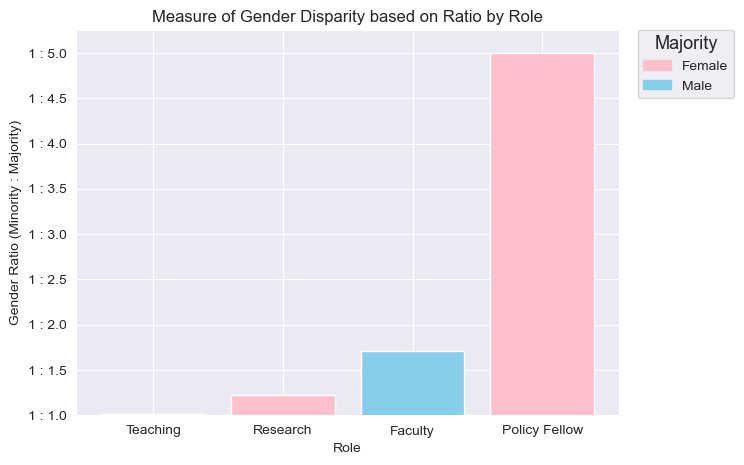

In [48]:
plot_df = by_role.sort_values('Ratio')

plt.figure(figsize=(7, 5))
colors = plot_df['Majority'].map({'Male': 'skyblue', 'Female': 'pink'})  # Color mapping
plt.bar(plot_df.index, plot_df['Ratio'], color=colors)
plt.xlabel('Role')
plt.ylabel('Gender Ratio (Minority : Majority)')
plt.ylim(bottom=1)
plt.title('Measure of Gender Disparity based on Ratio by Role')

formatter = FuncFormatter(lambda x, pos: f"1 : {round(x, 1)}")
plt.gca().yaxis.set_major_formatter(formatter)

# Custom legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
legend_labels = {'Female': 'pink', 'Male': 'skyblue'}
custom_handles = [plt.Rectangle((0,0),1,1, color=legend_labels[label]) for label in legend_labels]
plt.legend(custom_handles, legend_labels.keys(), title="Majority", loc='upper right', bbox_to_anchor=(1.225, 1.02), title_fontsize='13')

plt.show()

Interesting observations based on Analysis 3 and Plot 3:
- Out of the 4 roles, 3 of them have a Female majority with `Faculty` role being the only one with Male majority.
- Staff with `Teaching` role has a very balanced gender distribution with a ratio very close 1:1.
- Staff with `Policy Fellow` role has the most severe gender disparity with the male to female ratio of 1:5. However, looking at the `Total` attribute, this role has a significantly less total staff (24) compared to other roles (200+), which might be a factor of this severe gender disparity.
- The data suggests that the only role with Male majority is the `Faculty` role, which is tied to leadership roles. Thus, this suggests that Male staff dominates leadership roles compared to Female staff.

#### Analysis 4: Gender Distribution by Role
_This part of the analysis uses the whole cleaned DataFrame._

In [49]:
by_rank = df.pivot_table(index='rank', columns='gender', values='name', aggfunc='count')
by_rank = get_analysis(by_rank)
by_rank

gender      Female  Male  Total  Female Percentage  Male Percentage Majority  \
rank                                                                           
Assistant      149   118    267           0.558052         0.441948   Female   
Associate      112   136    248           0.451613         0.548387     Male   
Full           138   303    441           0.312925         0.687075     Male   
Non-tenure     613   646   1259           0.486894         0.513106     Male   

gender         Ratio  
rank                  
Assistant   1.262712  
Associate   1.214286  
Full        2.195652  
Non-tenure  1.053834

#### Plot 4: Bar Chart of the Gender Disparity based on Gender Ratio by Rank

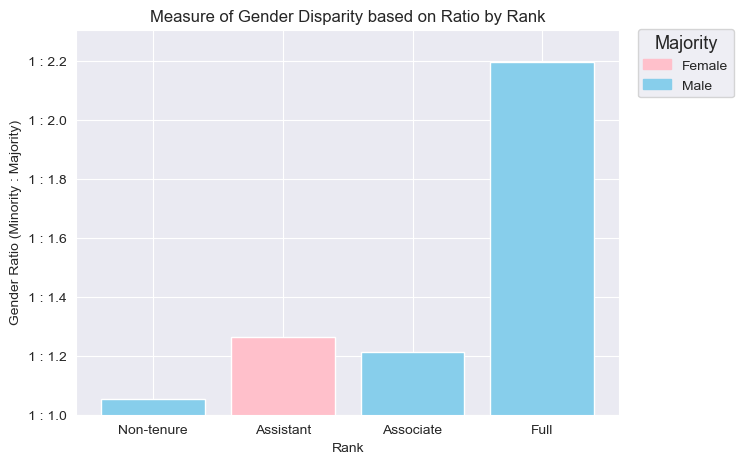

In [50]:
plot_df = by_rank.sort_values('Ratio')
plot_df = plot_df.iloc[[0, 2, 1, 3], :] # Rearranging based on rank

plt.figure(figsize=(7, 5))
colors = plot_df['Majority'].map({'Male': 'skyblue', 'Female': 'pink'})  # Color mapping
plt.bar(plot_df.index, plot_df['Ratio'], color=colors)
plt.xlabel('Rank')
plt.ylabel('Gender Ratio (Minority : Majority)')
plt.ylim(bottom=1)
plt.title('Measure of Gender Disparity based on Ratio by Rank')

formatter = FuncFormatter(lambda x, pos: f"1 : {round(x, 1)}")
plt.gca().yaxis.set_major_formatter(formatter)

# Custom legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
legend_labels = {'Female': 'pink', 'Male': 'skyblue'}
custom_handles = [plt.Rectangle((0,0),1,1, color=legend_labels[label]) for label in legend_labels]
plt.legend(custom_handles, legend_labels.keys(), title="Majority", loc='upper right', bbox_to_anchor=(1.225, 1.02), title_fontsize='13')

plt.show()

Interesting observations based on Analysis 4 and Plot 4:
- Out of the 4 ranks, 3 of them have a Male majority, which is the opposite of what is shown for roles.
- However, this time, the scales are much smaller, which suggests that in general, there is less gender disparity when comparing by ranks.
- Again, we can see a common theme of Female staff being the majority in non-leadership roles (rank of Assistant).
- Staff with the rank of `Non-tenure` have a gender ratio that is close to 1:1
- The staff with rank `Full` has the most gender disparity, with a female to male ratio of 1:2.2, despite having the second largest `Total` measure.

#### Analysis 5: Gender Distribution by Role-Rank Combination
_This part of the analysis uses the cleaned DataFrame which have non-empty values for both Rank and Role._

In [51]:
by_role_rank = df[(df['role'].notnull()) & (df['rank'].notnull())]
by_role_rank = by_role_rank.pivot_table(index=['role', 'rank'], columns='gender', values='name', aggfunc='count').fillna(0)
by_role_rank['Total'] = by_role_rank['Female'] + by_role_rank['Male']
by_role_rank[["Female Percentage", "Male Percentage"]] = by_role_rank[["Female", "Male"]].apply(lambda x: x/sum(x), axis = 1)
by_role_rank['Percentage Difference'] = by_role_rank['Male Percentage'] - by_role_rank['Female Percentage']
by_role_rank

gender                    Female  Male  Total  Female Percentage  \
role          rank                                                 
Faculty       Assistant       91    84    175           0.520000   
              Associate       97   119    216           0.449074   
              Full           107   284    391           0.273657   
              Non-tenure      46    97    143           0.321678   
Policy Fellow Non-tenure      20     4     24           0.833333   
Research      Assistant       42    24     66           0.636364   
              Associate        4     7     11           0.363636   
              Non-tenure     108    95    203           0.532020   
Teaching      Assistant       16    10     26           0.615385   
              Associate       11    10     21           0.523810   
              Full            31    19     50           0.620000   
              Non-tenure     439   450    889           0.493813   

gender                    Male Percentage  Percentage Difference  
role          rank                                                
Faculty       Assistant          0.480000              -0.040000  
              Associate          0.550926               0.101852  
              Full               0.726343               0.452685  
              Non-tenure         0.678322               0.356643  
Policy Fellow Non-tenure         0.166667              -0.666667  
Research      Assistant          0.363636              -0.272727  
              Associate          0.636364               0.272727  
              Non-tenure         0.467980              -0.064039  
Teaching      Assistant          0.384615              -0.230769  
              Associate          0.476190              -0.047619  
              Full               0.380000              -0.240000  
              Non-tenure         0.506187               0.012373

In [52]:
percent_diff = by_role_rank.reset_index()
percent_diff = percent_diff.pivot(index='role', columns='rank', values='Percentage Difference').fillna(0)
percent_diff

rank           Assistant  Associate      Full  Non-tenure
role                                                     
Faculty        -0.040000   0.101852  0.452685    0.356643
Policy Fellow   0.000000   0.000000  0.000000   -0.666667
Research       -0.272727   0.272727  0.000000   -0.064039
Teaching       -0.230769  -0.047619 -0.240000    0.012373

Some things to note:
- The percentage difference of staff with `Policy Fellow` role is 0 for all ranks except `Non-tenure` because of the assumption we made during data cleaning, and not because the combination has a balanced gender distribution.
- The `Research` role, `Full` rank is not a similar case. The 0 percentage difference is instead caused by the absence of staff in that combination of role and rank, which means that based on how we allocated role and rank, no staff is put in this combination.

#### Plot 5: Heatmap of Gender Percentage Difference by Rank-Role Combination

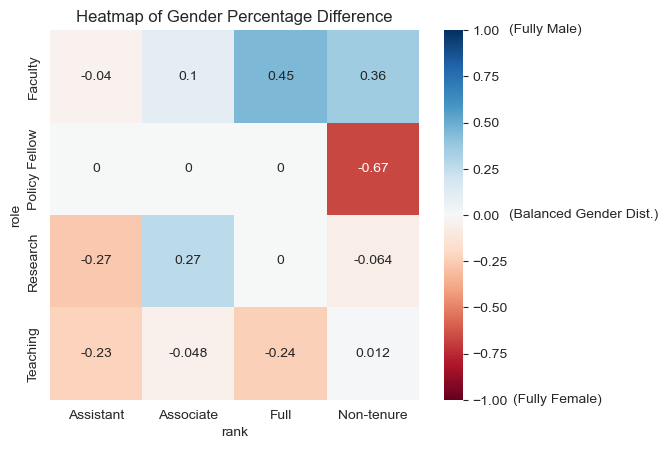

In [53]:
sns.heatmap(percent_diff, annot=True, square=True, vmin=-1, vmax=1, cmap='RdBu')
plt.title('Heatmap of Gender Percentage Difference')
            
cbar = plt.gca().collections[0].colorbar
cbar.ax.text(3.75, -1.0, '(Fully Female)', va='center', ha='left')
cbar.ax.text(3.5, 1.0, '(Fully Male)', va='center', ha='left')
cbar.ax.text(3.5, 0, '(Balanced Gender Dist.)', va='center', ha='left');

Interesting observations from Analysis 5 and Plot 5:
- There is a clear Male majority within staff with the `Faculty` role, with the only rank to have a small Female majority is the `Assistant` rank.
- The inverse can be said for `Teaching` roles with most ranks are dominated by Female staff, where the only rank with a slight Male majority is the `Non-tenure` rank.
- For staff with in `Research` roles, the `Assistant` rank is dominated by Female, while the `Associate` rank is dominated by Male.
- The Assistant rank is solely dominated by Female staff across all roles.
- For staff with rank of `Full`, the `Teaching` role is dominated by Female staff, while the `Faculty` role is heavily dominated by Male staff.

___
<a id="conclusion"></a>
### Conclusion

Based on everything we have analysed and visualised so far, it can be said that in general, LSE as a whole does have a balanced gender distribution amongst its staff [(Plot 1)](#plot-1). However, when looking at parts of the whole picture, such as by departments, prevailing gender stereotypes persist, as evidenced by the unequal gender ratios observed across several departments [(Plot 2.4)](#plot-2.4). Scientific and quantitative related departments such as `Department of Mathematics`, `Department of Statistics` and `Department of Philosophy, Logic, and Scientific Method` are mostly dominated by Men staff. Ironically, it can also be seen that the `Department of Gender Studies` has one of the most unbalanced gender distribution amongst all other departments. Addressing these disparities demands concerted efforts to challenge stereotypes and foster environments that promote gender diversity and equality across all fields of study.

   An interesting insight gained from our analysis is that the number of staff in each department has a correlation with the gender disparity, meaning in general, the larger a department gets, the higher tendency of it having a more balanced ratio of Male to Female [(Plot 2.5, correlation matrix of `Total`, `Ratio`, and `Percentage Difference`)](#plot-2.5). However, this might just be caused by the nature of the data collected, since when the Total number of staff in a department is small, each person's gender affect the distribution greatly compared to when the department size is large.

Regarding the gender distribution of LSE staff by role/ranks ([Plot 3](#plot-3) and [Plot 4](#plot-4)), another gender stereotypes is seen as leadership positions (implied from the role `Faculty`) exhibit a higher percentage of Male staff, while the subordinates (such as those with rank of `Assistant`) are comprised majorly by Female staff. This shows underlying gender inequalities, particularly in leadership representation. The skewed distribution of genders across various roles underscores the need for a more nuanced examination of gender dynamics within the institution. Specifically, addressing disparities in leadership roles is crucial for achieving gender equity and fostering an inclusive environment that promotes equal opportunities for all staff members.

Important limitations and assumptions of this analysis:
- The insights gained from our research project are based on the assumption that the data we gathered through web-scraping are correct and up to date. In addition, the gender attribute of each staff is only deduced either through their personal LSE link, or using a name-genderizer API (Namsor).
- Looking at some of the departments that have a low `Total` attribute, there are certain departments that have a number of the staff in their department coming from other departments, but does not have a separate entry in the people's page (our source for web scraping). For example, the [Data Science Institute (DSI)](https://www.lse.ac.uk/DSI/People), has a lot more staff than 4 (it's `Total` attribute in [Analysis 2](#analysis-2)). However, clicking at some of the links in their people page reveals that most of its staff shows another department instead of DSI on their personal LSE page.

_Any misquote of numerical values may be caused by change of data at the time of writing the analysis, compared to time of running the code. For example, by running the code on a new date, you will get different but close numerical values for certain calculations/statistics._

___
<a id="extras"></a>
### Extras

In this supplementary exploration, we revisit an early-stage approach developed before our discovery of the comprehensive LSE people page. Our initial methodology involved navigating through departmental pages to extract names, a challenging endeavor given the varying webpage layouts across departments. While this code encompasses everyone affiliated with a department, including visitors, PHD students, and researchers, it deviates from our main analysis by not solely focusing on staff members. Furthermore, it may feature duplicate entries for staff who hold multiple roles or are associated with multiple departments.
<br><br>
It's important to underscore that this analysis should be regarded as an additional perspective, rather than the primary focus of our project. Despite the limitations inherent in its development—acknowledged through the presence of numerous if statements to handle differing webpage structures—this code provides unique insights into our dataset.
<br><br>
For a more comprehensive and up-to-date version of our analysis, complete with detailed explanations and code, we recommend referring to the Extras_Data_source notebook. In the sections below, we showcase SQL queries performed on the database generated by our initial scraping efforts. While we ultimately transitioned away from this approach in favor of the main people page, exploring this early attempt uncovers valuable insights and addresses certain limitations inherent in our main analysis.

In [16]:
%load_ext sql
%config SqlMagic.displaylimit = None

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


displaylimit: Value None will be treated as 0 (no limit)

In [18]:
%sql sqlite:///data/extras_data.db

As we can see from the code below, there are way more roles than in our main project:

In [19]:
%sql SELECT COUNT(*) AS Total_Roles, COUNT(DISTINCT role_name) AS Distinct_Roles FROM Roles;

Running query in 'sqlite:///data/extras_data.db'

+-------------+----------------+
| Total_Roles | Distinct_Roles |
+-------------+----------------+
|     214     |      145       |
+-------------+----------------+

Furthermore, the initial webscraping code allows the same person to appear in different departments; this addresses the problem of our main code, which does not have duplicate names, as can be seen by the "4 staff members" in the data science institute from the main code.

As can be seen below, there are way more people per department in this database:

In [ ]:
%%sql

SELECT
    department_name,
    COUNT(*) AS Number_of_People
FROM Person
GROUP BY department_name
ORDER BY Number_of_People DESC;

And some people can appear multiple times:

In [ ]:
%%sql

SELECT
    person_name,
    COUNT(*) AS Appearances
FROM Person
GROUP BY person_name
HAVING COUNT(*) = (
    SELECT MAX(Appearances)
    FROM (
        SELECT COUNT(*) AS Appearances
        FROM Person
        GROUP BY person_name
    ) AS max_counts
)
ORDER BY Appearances DESC;

The queries below demonstrate the nuance between our main analysis and our initial analysis:

In [20]:
%sql SELECT COUNT(*)-COUNT(DISTINCT person_name) AS People_Appearing_In_Different_Roles_And_Or_departments FROM Person;

Running query in 'sqlite:///data/extras_data.db'

+--------------------------------------------------------+
| People_Appearing_In_Different_Roles_And_Or_departments |
+--------------------------------------------------------+
|                          423                           |
+--------------------------------------------------------+

In [23]:
%%sql SELECT
    p.department_name,
    SUM(g.gender='Male') AS Male_Staff,
    SUM(g.gender='Female') AS Female_Staff,
    ROUND((CAST(SUM(g.gender='Male') AS FLOAT) * 100.0) / COUNT(*), 1) AS Male_Percentage,
    ROUND((CAST(SUM(g.gender='Female') AS FLOAT) * 100.0) / COUNT(*), 1) AS Female_Percentage
FROM Person p
JOIN Gender g ON p.person_name = g.name
GROUP BY p.department_name
ORDER BY Male_Percentage DESC;

Running query in 'sqlite:///data/extras_data.db'

+-------------------------------------------------------+------------+--------------+-----------------+-------------------+
|                    department_name                    | Male_Staff | Female_Staff | Male_Percentage | Female_Percentage |
+-------------------------------------------------------+------------+--------------+-----------------+-------------------+
|               Department of Mathematics               |     82     |      26      |       75.9      |        24.1       |
|                Department of Economics                |    277     |     128      |       68.4      |        31.6       |
|                Department of Government               |    135     |      67      |       66.8      |        33.2       |
| Department of Philosophy, Logic and Scientific Method |     28     |      14      |       66.7      |        33.3       |
|                 Department of Finance                 |     90     |      49      |       64.7      |        35.3       |
|                Department of Accounting               |     33     |      18      |       64.7      |        35.3       |
|                Department of Statistics               |     60     |      33      |       64.5      |        35.5       |
|             Department of Economic History            |     68     |      38      |       64.2      |        35.8       |
|                School of Public Policy                |     91     |      51      |       64.1      |        35.9       |
|          Department of International History          |     37     |      22      |       62.7      |        37.3       |
|                 Data Science Institute                |     67     |      40      |       62.6      |        37.4       |
|                   European Institute                  |     75     |      52      |       59.1      |        40.9       |
|                Department of Sociology                |     71     |      53      |       57.3      |        42.7       |
|         Department of International Relations         |     63     |      47      |       57.3      |        42.7       |
|        Department of Geography and Environment        |    139     |     120      |       53.7      |        46.3       |
|                     LSE Law School                    |     82     |      73      |       52.9      |        47.1       |
|              Department of Social Policy              |     46     |      41      |       52.9      |        47.1       |
|                   Marshall Institute                  |     23     |      21      |       52.3      |        47.7       |
|               Department of Methodology               |     36     |      33      |       52.2      |        47.8       |
|              Department of Health Policy              |     71     |      74      |       49.0      |        51.0       |
|  Department of Psychological and Behavioural Science  |     86     |      97      |       47.0      |        53.0       |
|         Department of Media and Communications        |     45     |      55      |       45.0      |        55.0       |
|          International Inequalities Institute         |     70     |      87      |       44.6      |        55.4       |
|                Department of Management               |     85     |     106      |       44.5      |        55.5       |
|        Department of International Development        |     43     |      59      |       42.2      |        57.8       |
|               Department of Anthropology              |     29     |      40      |       42.0      |        58.0       |
|                    Language Centre                    |     23     |      33      |       41.1      |        58.9       |
|            Firoz Lalji Institute for Africa           |     25     |      52      |       32.5      |        67.5       |
|              Department of Gender Studies             |     7      |      51      |       12.1      |        87.9       |
+-------------------------------

Ordering the departments by the closeness of their gender percentage to 50%:

In [ ]:
%%sql

SELECT
    p.department_name,
    SUM(g.gender='Male') AS Male_Staff,
    SUM(g.gender='Female') AS Female_Staff,
    ROUND((CAST(SUM(g.gender='Male') AS FLOAT) * 100.0) / COUNT(*), 1) AS Male_Percentage,
    ROUND((CAST(SUM(g.gender='Female') AS FLOAT) * 100.0) / COUNT(*), 1) AS Female_Percentage,
    ROUND(ABS(ROUND((CAST(SUM(g.gender='Male') AS FLOAT) * 100.0) / COUNT(*), 1) - 50), 1) AS Percentage_Difference
FROM Person p
JOIN Gender g ON p.person_name = g.name
GROUP BY p.department_name
ORDER BY Percentage_Difference ASC;

What's interesting is that the overall ratio is also different, as the first webscraping code we tried encompasses all people associated to a department, not only staff:

In [21]:
%%sql SELECT
    SUM(gender='Male') AS Male_Staff,
    SUM(gender='Female') AS Female_Staff,
    ROUND(CAST(SUM(gender='Male') AS FLOAT) / SUM(gender='Female'), 2) AS Male_To_Female_Ratio ,
    ROUND((CAST(SUM(gender='Male') AS FLOAT) * 100.0) / COUNT(*), 1) AS Male_Percentage,
    ROUND((CAST(SUM(gender='Female') AS FLOAT) * 100.0) / COUNT(*), 1) AS Female_Percentage
FROM Gender;

Running query in 'sqlite:///data/extras_data.db'

+------------+--------------+----------------------+-----------------+-------------------+
| Male_Staff | Female_Staff | Male_To_Female_Ratio | Male_Percentage | Female_Percentage |
+------------+--------------+----------------------+-----------------+-------------------+
|    1741    |     1418     |         1.23         |       55.1      |        44.9       |
+------------+--------------+----------------------+-----------------+-------------------+

Finally, the biggest difference in the 2 webscrapes. There are way more roles from our initial webscrape database, and this shows that not only is there gender inequality for some departments, but that this inequality also spreads to roles:

In [24]:
%%sql

SELECT
    p.role_name,
    (SELECT COUNT(*) FROM Roles r WHERE r.role_name = p.role_name) AS Role_Count,
    SUM(g.gender='Male') AS Male_Staff,
    SUM(g.gender='Female') AS Female_Staff,
    ROUND((CAST(SUM(g.gender='Male') AS FLOAT) * 100.0) / COUNT(*), 1) AS Male_Percentage,
    ROUND((CAST(SUM(g.gender='Female') AS FLOAT) * 100.0) / COUNT(*), 1) AS Female_Percentage
FROM Person p
JOIN Gender g ON p.person_name = g.name
WHERE p.role_name IN (
    SELECT role_name
    FROM Roles
    GROUP BY role_name
    HAVING COUNT(*) > 1
)
GROUP BY p.role_name
ORDER BY Male_Percentage DESC;

Running query in 'sqlite:///data/extras_data.db'

+-------------------------------------+------------+------------+--------------+-----------------+-------------------+
|              role_name              | Role_Count | Male_Staff | Female_Staff | Male_Percentage | Female_Percentage |
+-------------------------------------+------------+------------+--------------+-----------------+-------------------+
|            class teachers           |     2      |     51     |      13      |       79.7      |        20.3       |
|          academic visitors          |     2      |     21     |      6       |       77.8      |        22.2       |
|        visiting appointments        |     2      |     21     |      8       |       72.4      |        27.6       |
|           academic faculty          |     3      |     62     |      25      |       71.3      |        28.7       |
|            guest teachers           |     5      |     21     |      10      |       67.7      |        32.3       |
|               faculty               |     3      |     53     |      30      |       63.9      |        36.1       |
|        senior management team       |     2      |     7      |      4       |       63.6      |        36.4       |
|          research students          |     8      |    231     |     138      |       62.6      |        37.4       |
|                 head                |     5      |     39     |      24      |       61.9      |        38.1       |
|               emeritus              |     2      |     11     |      8       |       57.9      |        42.1       |
|            visiting staff           |     6      |     83     |      62      |       57.2      |        42.8       |
|            academic staff           |     10     |    189     |     158      |       54.5      |        45.5       |
|             lse fellows             |     2      |     4      |      4       |       50.0      |        50.0       |
|           visiting fellows          |     5      |     61     |      63      |       49.2      |        50.8       |
|            research staff           |     6      |     18     |      20      |       47.4      |        52.6       |
|             phd students            |     4      |     66     |      77      |       46.2      |        53.8       |
|           research staff            |     2      |     6      |      9       |       40.0      |        60.0       |
| graduate teaching assistants (gtas) |     2      |     11     |      18      |       37.9      |        62.1       |
|     professional services staff     |     17     |     82     |     188      |       30.4      |        69.6       |
+-------------------------------------+------------+------------+--------------+-----------------+-------------------+

This table show what our main analysis could not, the gender ratio is heavily skewed depending on what role the person holds. Notably, roles within the Professional Services Staff (PSS) category predominantly comprise women, while leadership positions exhibit a higher percentage of males. Despite the overall gender ratio at LSE hovering around 55% male and 45% female, this figure belies underlying inequalities, particularly in leadership representation. It is also interesting to note that most visitors are male. The skewed distribution of genders across various roles underscores the need for a more nuanced examination of gender dynamics within the institution. Specifically, addressing disparities in leadership roles is crucial for achieving gender equity and fostering an inclusive environment that promotes equal opportunities for all staff members.